## This notebook is to demonstrate building and running GBDX Workflows - we'll run the CarDetection_aop task as an example

### First we'll display the image we'll be working with using a CatalogImage request in the notebook. All further processing of this image will not be run using Notebooks processing - we'll deploy a GBDX Workflow API request to run this algorithm against a full image strip. Use WV3 image 1040010047154B00 for this example.

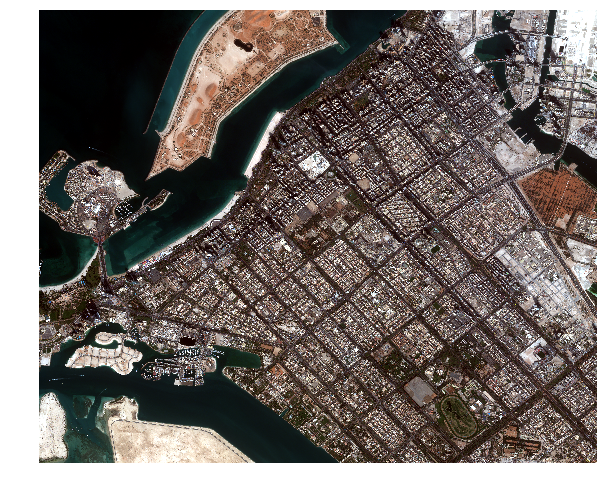

In [1]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '1040010047154B00')
bbox = env.inputs.get('bbox', '54.31262969970703, 24.435585019920392, 54.400863647460945, 24.50714328310284')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)

### To begin, we'll examine which GBDX tasks we have available to us in our task registry. Need to import gbdxtools and json so we can read the output in a notebook.

In [2]:
# Import GBDX libraries
from gbdxtools import Interface
from gbdxtools.task import env
from gbdxtools import CatalogImage
import json

# Initialize gbdx interface
gbdx = Interface()
gbdx_info = gbdx.s3.info

#List available tasks in my task registry:
conn = gbdx.gbdx_connection
r = conn.get("https://geobigdata.io/workflows/v1/tasks")
print("\n".join(task for task in r.json()["tasks"]))

AComp:1.1.29
AComp:1.1.30
AComp:1.1.32
AComp:1.2.16
AComp:1.2.17
AComp:1.2.18
AComp:1.2.21
AComp:1.2.4
AComp_1.0-debug:0.0.1
AComp_internal:1.1.29
AComp_internal:1.1.30
AComp_internal:1.1.32
AOP_Strip_Processor:0.0.4
AOP_Workorder:0.0.4
Auto_Ordering:0.0.1
Auto_Ordering_OR2A:0.0.6
CarDetectionPrep:0.0.1
CarDetection_aop:0.0.1
CloudHarness_Anonymous_Task:0.0.1
CloudOptimizedGeoTIFF:0.12.0
CloudOptimizedGeoTIFF:0.2.0
CloudOptimizedGeoTIFF:0.2.1
CloudOptimizedGeoTIFF:1.0.4
CloudOptimizedGeoTIFF:2.0.1
CloudPuncher:0.0.1
CloudPuncher:0.4.11
CloudPuncher:0.4.12
CloudPuncher:0.4.13
CloudPuncher:0.4.19
CloudTracker:0.3.0
CloudTracker:0.3.1
CompareVectors:0.1.4
ConcreteAsphaltFinder:0.0.1
ConcreteAsphaltFinder:0.0.10
ConcreteAsphaltFinder:0.0.2
ConcreteAsphaltFinder:0.0.3
ConcreteAsphaltFinder:0.0.4
ConcreteAsphaltFinder:0.0.5
ConcreteAsphaltFinder:0.0.6
ConcreteAsphaltFinder:0.0.7
ConcreteAsphaltFinder:0.0.9
CropGeotiff:0.0.6
CustomDEMPrep:0.0.1
DGLayers:3.0.1
DGLayers:3.0.2
DGLayers:3.0.3
DGL

### For this workflow we're going to start with a L1B image. To find the S3 location of the image we can "order" the image - if the image is not available for GBDX workflows an 'ordered' status will show. If available the S3 location of the image will be returned:

In [3]:
from gbdxtools import Interface
gbdx = Interface()

order_id=gbdx.ordering.order('1040010047154B00')

status=gbdx.ordering.status(order_id)

print (order_id)
print (status)

1d8b94b3-9157-409a-9dfc-1993adb7ee29
[{'acquisition_id': '1040010047154B00', 'state': 'delivered', 'location': 's3://receiving-dgcs-tdgplatform-com/059656163010_01_003'}]


### We'll need 4 GBDX tasks to complete the car detection workflow.
### 1. Auto_Ordering
This orders a CatID into GBDX, if it already exists it simply outputs the S3 location of the image.
### 2. AOP_Strip_Processor
Advanded Ortho Processor - This orthorectifies the image and prepares it for furhter analysis
### 3. CarDetectionPrep
This prepares the AOP output ready for car detection
### 4. CarDetection_AOP
Runs the card detection on the CarDetectionPrep output.

### We can view a task's defined inputs and outputs as follows:

In [4]:
task = gbdx.Task("Auto_Ordering")

print (task.inputs)
print (task.outputs)

cat_id

s3_location



In [5]:
task = gbdx.Task("AOP_Strip_Processor")

print (task.inputs)
print (task.outputs)

dra_mode
data
dra_low_cutoff
dra_baselayer_prefix
dra_high_cutoff
dra_gamma
enable_dra
bba
ortho_pixel_size
enable_acomp
bands
ortho_epsg
ortho_tiling_scheme
ortho_dem_specifier
parts
dra_bit_depth
tiling_zoom_level
enable_tiling
ortho_interpolation_type
enable_pansharpen

data
log



### We can view the description of a task input or output as follows:

In [6]:
task.inputs.enable_dra

Port enable_dra:
	type: string
	description: Enable/disable dynamic range adjustment. Choices are 'true' or 'false'. Default is 'true'.
	multiplex: False
	required: False
	Value: None

### Let's view the inputs and outputs for the other 2 tasks:

In [9]:
task = gbdx.Task("CarDetectionPrep")

print (task.inputs)
print (task.outputs)

aop_data

data_b
data_c
data_a



In [11]:
task.inputs.aop_data

Port aop_data:
	type: data
	description: This is the name of the directory that will contain the finished AOP geotiff and imd files
	multiplex: False
	required: True
	Value: None

In [12]:
task = gbdx.Task("CarDetection_aop")

print (task.inputs)
print (task.outputs)

qa_AoiPolygonFiles
use_osmLot
is_fastortho_strip
externalLot
externalParkingLotOnly
databaseConnection
model_resolution
carcounting_strips
createQAResult
qa_AOIs
processStripNotInAOI
part_index
detection_AOIs
lane_width
detection_AoiPolygonFiles
colorMode
input_road
s3_credential

carDetectionOutput
carDetectionQaOutput



### Now we get to the important part - the following cell defines the complete GBDX Workflow. Defining the input CatID, the output S3 folder destination and the workflow itself.

In [13]:
#Car Detection Workflow

#Inputs:
catid = '1040010047154B00'

#Output destination
destination = 'junk/ADMcardetection/1040010047154B00_cd'

#Image auto order TASK1 - will place the catID order, or if available returns the S3 location of the image
order_task = gbdx.Task("Auto_Ordering",cat_id=catid)
order_task.impersonation_allowed = True
data_loc = order_task.outputs.s3_location.value
    
print (data_loc)

#TASK2: Build the AOP task needed for the workflow
aoptask = gbdx.Task("AOP_Strip_Processor", data=data_loc, enable_acomp=False, 
                    enable_pansharpen=False, enable_dra=False,ortho_epsg="UTM",ortho_pixel_size="0.5")

#TASK3: add the CarDetectionPrep task
dataprep_task = gbdx.Task("CarDetectionPrep",aop_data=aoptask.outputs.data.value)

#TASK4: Car Detection task
cd_task_a = gbdx.Task("CarDetection_aop",carcounting_strips=dataprep_task.outputs.data_a.value,part_index='1', 
                      is_fastortho_strip="True",colorMode='4',createQAResult="False",processStripNotInAOI="False")
cd_task_b = gbdx.Task("CarDetection_aop",carcounting_strips=dataprep_task.outputs.data_b.value,part_index='2', 
                      is_fastortho_strip="True",colorMode='4',createQAResult="False",processStripNotInAOI="False")
cd_task_c = gbdx.Task("CarDetection_aop",carcounting_strips=dataprep_task.outputs.data_c.value,part_index='3', 
                      is_fastortho_strip="True",colorMode='4',createQAResult="False",processStripNotInAOI="False")

#Create the workflow
workflow = gbdx.Workflow([order_task,aoptask,dataprep_task,cd_task_a,cd_task_b,cd_task_c])
#Save the data
# workflow.savedata(aoptask.outputs.data, location=destination + "_ortho")
workflow.savedata(cd_task_a.outputs.carDetectionOutput, location=destination)
workflow.savedata(cd_task_b.outputs.carDetectionOutput, location=destination)
workflow.savedata(cd_task_c.outputs.carDetectionOutput, location=destination)

#Initiate the workflow
workflow.execute()

#print out the workflow status and ID

print (workflow.id)
print (workflow.status)

source:Auto_Ordering_a7a25d7e:s3_location
5110604510272772581
{'state': 'pending', 'event': 'submitted'}


### The printed outputs of this are the s3 location and the workflow ID & Status. We can monitor the progress of the workflow using the workflow ID as follows:

In [14]:
#print workflow status and events
workflow_id = workflow.id #'5110604510272772581'

workflow_status=gbdx.workflow.status(workflow_id)
print (workflow_status)

workflow_events=gbdx.workflow.events(workflow_id)
print (json.dumps(workflow_events, indent=2))

{'state': 'pending', 'event': 'submitted'}
[
  {
    "task": "Auto_Ordering_a7a25d7e",
    "task_id": "5110604510231145089",
    "timestamp": "2019-04-22T11:58:52.931044+00:00",
    "when": "seconds ago",
    "note": "",
    "state": "pending",
    "event": "submitted"
  },
  {
    "task": "AOP_Strip_Processor_5879cabd",
    "task_id": "5110604510236261102",
    "timestamp": "2019-04-22T11:58:52.935352+00:00",
    "when": "seconds ago",
    "note": "",
    "state": "pending",
    "event": "submitted"
  },
  {
    "task": "CarDetectionPrep_e7d1ac58",
    "task_id": "5110604510248798852",
    "timestamp": "2019-04-22T11:58:52.941347+00:00",
    "when": "seconds ago",
    "note": "",
    "state": "pending",
    "event": "submitted"
  },
  {
    "task": "CarDetection_aop_aaf15da0",
    "task_id": "5110604510257175048",
    "timestamp": "2019-04-22T11:58:52.947260+00:00",
    "when": "seconds ago",
    "note": "",
    "state": "pending",
    "event": "submitted"
  },
  {
    "task": "CarDet

### Once the workflow has completed we can check the results and download from our S3 bucket. Open your Account Settings >> S3 Browser, and navigate to the output folder to view list of files